In [ ]:
"""
Copyright (c) 2022 Magdalena Fuentes, Bea Steers, Julia Wilkins
All rights reserved.

This source code is licensed under the BSD-3-Clause license found in the
LICENSE file in the root directory of this source tree.
"""

%load_ext autoreload
%autoreload 2

In [1]:
import os
import glob
import h5py
import json
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from eval_script import iou_score, giou_score
from collections import Counter

## Load predictions and index

In [2]:
PREDICTIONS_PATH = 'predictions/'

In [3]:
model_predictions = np.array(glob.glob(os.path.join(PREDICTIONS_PATH, "**", "*.h5")))
model_predictions

array(['predictions/tau2021_f2_scratch/TAU2021-f2-epoch051.h5',
       'predictions/tau2021_f3_scratch/TAU2021-f3-epoch103.h5',
       'predictions/tau2021_f1_scratch/TAU2021-f1-epoch052.h5',
       'predictions/tau2021_f0_scratch/TAU2021-f0-epoch047.h5',
       'predictions/tau2021_f4_scratch/TAU2021-f4-epoch046.h5'],
      dtype='<U53')

In [4]:
pred = {}
for file_path in model_predictions:
    print(file_path)
    with h5py.File(file_path,'r' ) as f:
        for uid in f.keys():
            pred[uid] = {
                'time': np.array(f[uid]['time']),
                'pred': np.array(f[uid]['pred']),
            }
print(len(pred))

predictions/tau2021_f2_scratch/TAU2021-f2-epoch051.h5
predictions/tau2021_f3_scratch/TAU2021-f3-epoch103.h5
predictions/tau2021_f1_scratch/TAU2021-f1-epoch052.h5
predictions/tau2021_f0_scratch/TAU2021-f0-epoch047.h5
predictions/tau2021_f4_scratch/TAU2021-f4-epoch046.h5
980


In [5]:
pred['103']['pred'].shape

(20, 4, 15)

In [6]:
INDEX_PATH = Path("TAU2021_final.json")
INDEX_PATH

PosixPath('TAU2021_final.json')

In [7]:
index = pd.read_json(INDEX_PATH).transpose()

In [8]:
with INDEX_PATH.open() as f:
    index = json.load(f)

df_index = pd.DataFrame.from_dict(index,orient='index')
df_index.head()

,path,events,non_identifiable_vehicle_sound,sr,format,channels,duration,fold
100,audio/magallanes0308_01_0.wav,"[{'label': 'car', 'start': 0.0, 'end': 10.0, '...",False,48000,WAV,2,10.0,4
101,audio/magallanes0308_01_1.wav,"[{'label': 'car', 'start': 0.0, 'end': 4.232, ...",False,48000,WAV,2,10.0,2
102,audio/magallanes0308_01_10.wav,"[{'label': 'car', 'start': 0.0, 'end': 1.638, ...",False,48000,WAV,2,10.0,2
103,audio/magallanes0308_01_11.wav,"[{'label': 'offscreen', 'start': 1.123, 'end':...",False,48000,WAV,2,10.0,1
104,audio/magallanes0308_01_12.wav,"[{'label': 'car', 'start': 3.723, 'end': 7.473...",False,48000,WAV,2,10.0,3


## EDA

### Class instance counts (number of frames) - index

In [56]:
class_instance_counts = {'car': 0, 'bus': 0, 'motorbike': 0, 'truck': 0, '-1': 0}

for k,v in index.items():
    for e in v['events']:
        if e['source'] == 'video':
            class_instance_counts[e['label']] += len(e['time'])
class_instance_counts = dict(sorted(class_instance_counts.items(), key=lambda item: item[1], reverse=True))

In [57]:
class_instance_counts.pop('-1')

61

In [58]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)

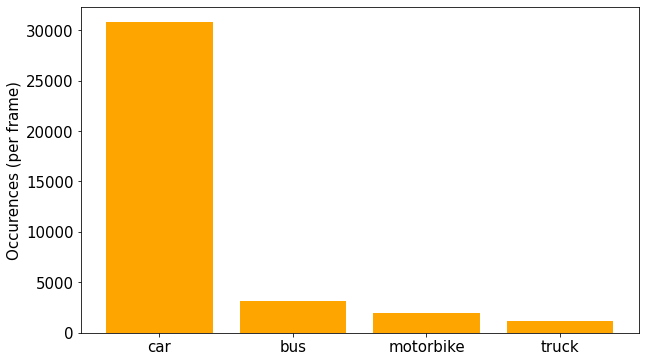

In [61]:
plt.figure(figsize=(10,6))
plt.bar(class_instance_counts.keys(), class_instance_counts.values(), color='orange')
# plt.title("Count of Class Occurences in Video Annotations (per frame)")
plt.ylabel("Occurences (per frame)")
plt.show()

In [52]:
class_instance_counts

{'car': 30795, 'bus': 3111, 'motorbike': 1973, 'truck': 1121}

In [53]:
total = sum(class_instance_counts.values())
for k,v in class_instance_counts.items():
    print(v/total)

0.8322972972972973
0.08408108108108107
0.053324324324324324
0.0302972972972973


### Number of vehicles in frame, per class and per occurence count

In [14]:
# Overall tracker
new_class_occ_d = {'car': [], 'bus': [], 'motorbike': [], 'truck': []}

for i in index.keys():
    # Current class tracker
    curr_class_d = {'car': [], 'bus': [], 'motorbike': [], 'truck': []}
    for e in index[i]['events']:
        if e['source'] == 'video':
            for c in ['car', 'bus', 'motorbike', 'truck']:
                if e['label'] == c:
                    curr_class_d[c].extend(e['time'])
    for cl, ti in curr_class_d.items():
        curr_d = dict(Counter(ti))
        new_class_occ_d[cl].extend(list(curr_d.values()))

/var/folders/0w/wxr2kl4x6p1gn3jb69dkpntr0000gn/T/ipykernel_53008/3837147762.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_class_occ_d.keys())


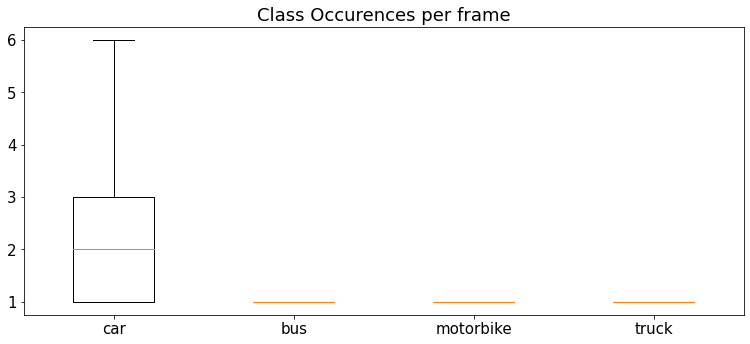

In [15]:
fig = plt.figure(figsize =(10, 4))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_title('Class Occurences per frame')
ax.set_xticklabels(new_class_occ_d.keys())
bp = ax.boxplot(list(new_class_occ_d.values()), showfliers=False)
plt.show()

# [LATEST] Prediction: Point-wise, frame-wise

In [16]:
fov = 120
num_regions = 15
fps = 2

In [17]:
tau_range = np.arange(0.01, 0.1, 0.01)
print(tau_range)

[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09]


## IOU: Center point estimation

In [18]:
# Trim it down to barebone overall scores
invalid_files = []
overall_per_class_scores = []
af_counter = 0
if_counter = 0

classes = sorted(['bus', 'car', 'motorbike', 'truck'])

scoring_dict = {}

for uid in tqdm(list(pred.keys())):
    scoring_dict[uid] = []
    
    for tau in tau_range:
        
        curr_tau_scores = {'tau': tau,
                           'active_frame_scores': {c: [] for c in classes},
                           'inactive_frame_scores': {c: [] for c in classes},
                           'active_frame_count': 0,
                           'inactive_frame_count': 0,
                           'mean_active_frame_scores': {c: None for c in classes},
                           'mean_inactive_frame_scores': {c: None for c in classes}
                            }
        
        file_index = index[uid]
        file_pred = pred[uid]

        # Frames, classes, regions
        f, c, r = file_pred['pred'].shape
        assert num_regions == r, r
        
        mask_per_class = file_pred['pred'].reshape((c, f, r))
        
        # Initialize scores dict for this file
        class_score = {c: None for c in classes}
 
        # Loop through the classes present in this file
        for class_index, class_name in enumerate(classes):
#             print("\n-----------------------------------")
#             print("Current class: ", class_name)
            # Get all events of this class
            events_for_this_class = [d for d in file_index['events'] if d['label'] == class_name]
            
            frame_scores = []

            # Loop through time
            for f, t in enumerate(np.arange(0, 10, 1/fps)): 
                # For a given time frame, collect all indexes of this class and their azimuth indexes
                
                # Initialize box of region size (1D) - one box per frame
                box = np.zeros((1, r))
                
                # For each event in this class
                for event in events_for_this_class:
                    if event['source'] == 'video':
                
                        # Basically a way of checking to see if the current events time
                        # array matches with a loop through possible timeframes
                        if any(np.abs(t-event['time']) < 1/fps):

                            # Get index to look for in azmith array
                            idx = np.argmin(np.abs(t-event['time']))

                            # update the box to have the latest index we grabbed
                            event_azimuth_idxs = np.round((event['azimuth'][idx] + fov / 2) / fov * (num_regions - 1)).astype(int)

                            try:
                                box[:,event_azimuth_idxs] = 1
                            except:
                                invalid_files.append(uid)
#                 print("Current time frame: ", t)
#                 print("GT BOX MASK: ", box)
#                 print("PRED BOX MASK: ", (mask_per_class[class_index,f,None]>tau)**1)
                
                # One score per frame per class
                score = iou_score(pred_mask=mask_per_class[class_index,f,None], # the pred is many instances
                                  gt_bbox_coords=[], 
                                  gt_box_mask=box, 
                                  th=tau, 
                                  frame_size=(1, r))
#                 print("Score: ", score[0])
#                 print("\n")
                # Add this to the scores list
                frame_scores.append(score[0])
                
                # COUNT INACTIVES ETC
                 # if GT is all zero = inactive frame
                if np.all((score[1] == 0)):
                    curr_tau_scores['inactive_frame_count'] += 1
                    if_counter+=1
                    curr_tau_scores['inactive_frame_scores'][class_name].append(score[0])
                else:
                    af_counter+=1
                    curr_tau_scores['active_frame_count'] += 1
                    curr_tau_scores['active_frame_scores'][class_name].append(score[0])
                
                                
            class_score[class_name] = frame_scores

        avgs = [np.mean(element) for element in class_score.values()]
        avgs.append(tau)
        avgs.append(uid)
        overall_per_class_scores.append(avgs)
        
        for k,v in curr_tau_scores['active_frame_scores'].items():
            curr_tau_scores['mean_active_frame_scores'][k] = np.mean(v)
        for k1,v1 in curr_tau_scores['inactive_frame_scores'].items():
            curr_tau_scores['mean_inactive_frame_scores'][k1] = np.mean(v1)
        scoring_dict[uid].append(curr_tau_scores)
        
df_labels = classes.append('tau')
classes.append('UID')
scoring_df = pd.DataFrame(overall_per_class_scores,columns=classes)
        

  0%|                                                      | 0/980 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████████| 980/980 [03:17<00:00,  4.96it/s]


In [19]:
af_counter / (af_counter+if_counter)

0.22815051020408164

In [20]:
# This is scores overall including active and inactive
scoring_df.groupby('tau').mean()

,bus,car,motorbike,truck
tau,,,,
0.01,0.392349,0.230045,0.422689,0.433428
0.02,0.511013,0.261745,0.554687,0.568350
0.03,0.588607,0.284994,0.635157,0.666138
0.04,0.649264,0.302075,0.698299,0.728565
0.05,0.681465,0.311492,0.730432,0.758865
0.06,0.699774,0.317312,0.749961,0.777559
0.07,0.714732,0.321288,0.766998,0.794787
0.08,0.728424,0.323723,0.780799,0.811016
0.09,0.738822,0.326479,0.793782,0.824381


In [21]:
def get_overall_mean_scores(score_dictionary, tau, active_or_inactive):
    classes = sorted(['bus', 'car', 'motorbike', 'truck'])
    res = []
    
    for u in score_dictionary.keys():
        for results in score_dictionary[u]:
            if results['tau'] == tau:
                if active_or_inactive == 'active':
                    res.append(results['mean_active_frame_scores'])
                elif active_or_inactive == 'inactive':
                    res.append(results['mean_inactive_frame_scores'])
    final = list(np.mean(pd.DataFrame(res)))
    final.append(tau)
    return final

In [22]:
# Final active results
con = []
for t in tau_range:
    con.append(get_overall_mean_scores(scoring_dict, t, 'active'))

active_results = pd.DataFrame(con, columns=['bus', 'car', 'motorbike', 'truck', 'tau'])
active_results

,bus,car,motorbike,truck,tau
0,0.062482,0.083099,0.056449,0.041268,0.01
1,0.047669,0.063870,0.040611,0.030999,0.02
2,0.040915,0.052722,0.031988,0.029064,0.03
3,0.037229,0.043628,0.022969,0.019151,0.04
4,0.030505,0.039138,0.022729,0.018400,0.05
5,0.028578,0.036989,0.022632,0.013525,0.06
6,0.026617,0.035045,0.022177,0.014355,0.07
7,0.025963,0.033175,0.020050,0.013398,0.08
8,0.023818,0.030641,0.018412,0.012246,0.09


In [23]:
# Final inactive results
con = []
for t in tau_range:
    con.append(get_overall_mean_scores(scoring_dict, t, 'inactive'))

inactive_results = pd.DataFrame(con, columns=['bus', 'car', 'motorbike', 'truck', 'tau'])
inactive_results

,bus,car,motorbike,truck,tau
0,0.432853,0.453653,0.451130,0.450744,0.01
1,0.574380,0.579839,0.597141,0.591920,0.02
2,0.665964,0.668189,0.685093,0.694230,0.03
3,0.739276,0.739753,0.754366,0.761297,0.04
4,0.778833,0.784780,0.790013,0.793081,0.05
5,0.801512,0.808222,0.810739,0.812958,0.06
6,0.818613,0.822535,0.828908,0.830977,0.07
7,0.834428,0.832528,0.843986,0.847863,0.08
8,0.847636,0.844609,0.857905,0.861955,0.09


## GIOU: Center point estimation

In [24]:
tau_range = np.arange(0.01, 0.1, 0.01)
fov = 120
num_regions = 15
fps = 2

In [25]:
# Trim it down to barebone overall scores
invalid_files = []
overall_per_class_scores = []

classes = sorted(['bus', 'car', 'motorbike', 'truck'])

scoring_dict = {}

for uid in tqdm(list(pred.keys())):
    scoring_dict[uid] = []
    
    for tau in tau_range:
        
        curr_tau_scores = {'tau': tau,
                           'active_frame_scores': {c: [] for c in classes},
                           'inactive_frame_scores': {c: [] for c in classes},
                           'active_frame_count': 0,
                           'inactive_frame_count': 0,
                           'mean_active_frame_scores': {c: None for c in classes},
                           'mean_inactive_frame_scores': {c: None for c in classes}
                            }
        
        file_index = index[uid]
        file_pred = pred[uid]

        # Frames, classes, regions
        f, c, r = file_pred['pred'].shape
        assert num_regions == r, r
        
        mask_per_class = file_pred['pred'].reshape((c, f, r))
        
        # Initialize scores dict for this file
        class_score = {c: None for c in classes}
 
        # Loop through the classes present in this file
        for class_index, class_name in enumerate(classes):
#             print("\n-----------------------------------")
#             print("Current class: ", class_name)
            # Get all events of this class
            events_for_this_class = [d for d in file_index['events'] if d['label'] == class_name]
            
            frame_scores = []

            # Loop through time
            for f, t in enumerate(np.arange(0, 10, 1/fps)): 
                # For a given time frame, collect all indexes of this class and their azimuth indexes
                
                # Initialize box of region size (1D) - one box per frame
                box = np.zeros((1, r))
                
                # For each event in this class
                for event in events_for_this_class:
                    if event['source'] == 'video':
                
                        # Basically a way of checking to see if the current events time
                        # array matches with a loop through possible timeframes
                        if any(np.abs(t-event['time']) < 1/fps):

                            # Get index to look for in azmith array
                            idx = np.argmin(np.abs(t-event['time']))

                            # POINTWISE SCORING
                            event_azimuth_idxs = np.round((event['azimuth'][idx] + fov / 2) / fov * (num_regions - 1)).astype(int)

                            try:
                                box[:,event_azimuth_idxs] = 1
                            except:
                                invalid_files.append(uid)
                                    
#                 print("Current time frame: ", t)
#                 print("GT BOX MASK INPUT: ", box)
#                 print("PRED BOX MASK INPUT: ", (mask_per_class[class_index,f,None]>tau)**1)
                # One score per frame per class
                score = giou_score(pred_mask=(mask_per_class[class_index,f,None]>tau)**1, # the pred is many instances
                                  gt_mask=box, 
                                  th=tau, 
                                  frame_size=(1, r))

#                 print("ENCLOSING BOX MASK: ", score[3])
#                 print("GIOU Score: ", score[0])

                # Add this to the scores list
                frame_scores.append(score[0])
                
                # COUNT INACTIVES ETC
                 # if GT is all zero = inactive frame
                if np.all((score[1] == 0)):
                    curr_tau_scores['inactive_frame_count'] += 1
                    curr_tau_scores['inactive_frame_scores'][class_name].append(score[0])
                else:
                    curr_tau_scores['active_frame_count'] += 1
                    curr_tau_scores['active_frame_scores'][class_name].append(score[0])
                
                                
            class_score[class_name] = frame_scores

        avgs = [np.mean(element) for element in class_score.values()]
        avgs.append(tau)
        avgs.append(uid)
        overall_per_class_scores.append(avgs)
        
        for k,v in curr_tau_scores['active_frame_scores'].items():
            curr_tau_scores['mean_active_frame_scores'][k] = np.mean(v)
        for k1,v1 in curr_tau_scores['inactive_frame_scores'].items():
            curr_tau_scores['mean_inactive_frame_scores'][k1] = np.mean(v1)
        scoring_dict[uid].append(curr_tau_scores)
        
df_labels = classes.append('tau')
classes.append('UID')
scoring_df = pd.DataFrame(overall_per_class_scores,columns=classes)
        

  0%|                                                      | 0/980 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████████| 980/980 [00:29<00:00, 32.83it/s]


In [26]:
# This is scores overall including active and inactive
scoring_df.groupby('tau').mean()

,bus,car,motorbike,truck
tau,,,,
0.01,0.376679,0.157928,0.414408,0.428169
0.02,0.495423,0.192700,0.546814,0.563950
0.03,0.576195,0.228948,0.628717,0.662979
0.04,0.640702,0.264403,0.694208,0.726254
0.05,0.675121,0.282747,0.727167,0.756239
0.06,0.693655,0.290290,0.746594,0.774743
0.07,0.708509,0.294323,0.763426,0.792371
0.08,0.721725,0.296441,0.777550,0.808803
0.09,0.731859,0.297904,0.790094,0.822563


In [27]:
# Final active results - GIOU
con = []
for t in tau_range:
    con.append(get_overall_mean_scores(scoring_dict, t, 'active'))

active_results = pd.DataFrame(con, columns=['bus', 'car', 'motorbike', 'truck', 'tau'])
active_results

,bus,car,motorbike,truck,tau
0,-0.047173,-0.029763,-0.050330,-0.071422,0.01
1,-0.068190,-0.039520,-0.055443,-0.062352,0.02
2,-0.054812,-0.031226,-0.053102,-0.033720,0.03
3,-0.024060,-0.013951,-0.031308,-0.027030,0.04
4,-0.010575,-0.005696,-0.022246,-0.035241,0.05
5,-0.014330,-0.004251,-0.020884,-0.046500,0.06
6,-0.017445,-0.005947,-0.026161,-0.031659,0.07
7,-0.023936,-0.007717,-0.022437,-0.028512,0.08
8,-0.029176,-0.011895,-0.026142,-0.024435,0.09


In [28]:
# Final inactive results - GIOU
con = []
for t in tau_range:
    con.append(get_overall_mean_scores(scoring_dict, t, 'inactive'))

inactive_results = pd.DataFrame(con, columns=['bus', 'car', 'motorbike', 'truck', 'tau'])
inactive_results

,bus,car,motorbike,truck,tau
0,0.432853,0.453653,0.451130,0.450744,0.01
1,0.574380,0.579839,0.597141,0.591920,0.02
2,0.665964,0.668189,0.685093,0.694230,0.03
3,0.739276,0.739753,0.754366,0.761297,0.04
4,0.778833,0.784780,0.790013,0.793081,0.05
5,0.801512,0.808222,0.810739,0.812958,0.06
6,0.818613,0.822535,0.828908,0.830977,0.07
7,0.834428,0.832528,0.843986,0.847863,0.08
8,0.847636,0.844609,0.857905,0.861955,0.09


## Boxwise Predictions

In [29]:
model_predictions_box = np.array(glob.glob(os.path.join('predictions_box', "**", "*.h5")))
print(model_predictions_box)

['predictions_box/tau2021_f0_scratch_box/TAU2021-f0-epoch100.h5'
 'predictions_box/tau2021_f3_scratch_box/TAU2021-f3-epoch096.h5'
 'predictions_box/tau2021_f1_scratch_box/TAU2021-f1-epoch084.h5'
 'predictions_box/tau2021_f4_scratch_box/TAU2021-f4-epoch090.h5'
 'predictions_box/tau2021_f2_scratch_box/TAU2021-f2-epoch093.h5']


In [30]:
pred_box = {}
for file_path in model_predictions_box:
    print(file_path)
    with h5py.File(file_path,'r' ) as f:
        for uid in f.keys():
            pred_box[uid] = {
                'time': np.array(f[uid]['time']),
                'pred': np.array(f[uid]['pred']),
            }
print(len(pred_box))

predictions_box/tau2021_f0_scratch_box/TAU2021-f0-epoch100.h5
predictions_box/tau2021_f3_scratch_box/TAU2021-f3-epoch096.h5
predictions_box/tau2021_f1_scratch_box/TAU2021-f1-epoch084.h5
predictions_box/tau2021_f4_scratch_box/TAU2021-f4-epoch090.h5
predictions_box/tau2021_f2_scratch_box/TAU2021-f2-epoch093.h5
980


## IOU: Boxwise

In [31]:
tau_range = np.arange(0.005, 0.01, 0.001)#np.arange(0.01, 0.1, 0.01)
fov = 120
num_regions = 15
fps = 2

In [32]:
# Trim it down to barebone overall scores
invalid_files = []
overall_per_class_scores = []

classes = sorted(['bus', 'car', 'motorbike', 'truck'])

scoring_dict = {}

for uid in tqdm(list(pred_box.keys())):
    scoring_dict[uid] = []
    
    for tau in [0.005]:
        
        curr_tau_scores = {'tau': tau,
                           'active_frame_scores': {c: [] for c in classes},
                           'inactive_frame_scores': {c: [] for c in classes},
                           'active_frame_count': 0,
                           'inactive_frame_count': 0,
                           'mean_active_frame_scores': {c: None for c in classes},
                           'mean_inactive_frame_scores': {c: None for c in classes}
                            }
        
        file_index = index[uid]
        file_pred = pred_box[uid]

        # Frames, classes, regions
        f, c, r = file_pred['pred'].shape
        assert num_regions == r, r
        
        mask_per_class = file_pred['pred'].reshape((c, f, r))
        
        # Initialize scores dict for this file
        class_score = {c: None for c in classes}
 
        # Loop through the classes present in this file
        for class_index, class_name in enumerate(classes):
#             print("\n-----------------------------------")
#             print("Current class: ", class_name)
            # Get all events of this class
            events_for_this_class = [d for d in file_index['events'] if d['label'] == class_name]
            
            frame_scores = []

            # Loop through time
            for f, t in enumerate(np.arange(0, 10, 1/fps)): 
                # For a given time frame, collect all indexes of this class and their azimuth indexes
                
                # Initialize box of region size (1D) - one box per frame
                box = np.zeros((1, r))
                
                # For each event in this class
                for event in events_for_this_class:
                    if event['source'] == 'video':
                
                        # Basically a way of checking to see if the current events time
                        # array matches with a loop through possible timeframes
                        if any(np.abs(t-event['time']) < 1/fps):

                            # Get index to look for in azmith array
                            idx = np.argmin(np.abs(t-event['time']))

                            # BOXWISE SCORING
                            event_aximuth_idxs_r = np.round((event['azimuth_right'][idx] + fov / 2) / fov * (num_regions - 1)).astype(int)
                            event_aximuth_idxs_l = np.round((event['azimuth_left'][idx] + fov / 2) / fov * (num_regions - 1)).astype(int)
                            try:
                                box[:,event_aximuth_idxs_l:event_aximuth_idxs_r+1] = 1
                            except:
                                invalid_files.append(uid)

                
                
                # One score per frame per class
                score = iou_score(pred_mask=mask_per_class[class_index,f,None], # the pred is many instances
                                  gt_bbox_coords=[], 
                                  gt_box_mask=box, 
                                  th=tau, 
                                  frame_size=(1, r))
                

                # Add this to the scores list
                frame_scores.append(score[0])
                
                # COUNT INACTIVES ETC
                 # if GT is all zero = inactive frame
                if np.all((score[1] == 0)):
                    curr_tau_scores['inactive_frame_count'] += 1
                    curr_tau_scores['inactive_frame_scores'][class_name].append(score[0])
                else:
#                     print("Current time frame: ", t)
#                     print("GT BOX MASK: ", box)
#                     print("PRED BOX MASK: ", (mask_per_class[class_index,f,None]>tau)**1)
#                     print("Score: ", score[0])
                    curr_tau_scores['active_frame_count'] += 1
                    curr_tau_scores['active_frame_scores'][class_name].append(score[0])
                
                                
            class_score[class_name] = frame_scores

        avgs = [np.mean(element) for element in class_score.values()]
        avgs.append(tau)
        avgs.append(uid)
        overall_per_class_scores.append(avgs)
        
        for k,v in curr_tau_scores['active_frame_scores'].items():
            curr_tau_scores['mean_active_frame_scores'][k] = np.mean(v)
        for k1,v1 in curr_tau_scores['inactive_frame_scores'].items():
            curr_tau_scores['mean_inactive_frame_scores'][k1] = np.mean(v1)
        scoring_dict[uid].append(curr_tau_scores)
        
df_labels = classes.append('tau')
classes.append('UID')
scoring_df = pd.DataFrame(overall_per_class_scores,columns=classes)
        

  0%|                                                      | 0/980 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|████████████████████████████████████████████| 980/980 [00:22<00:00, 43.47it/s]


In [33]:
# This is scores overall including active and inactive
scoring_df.groupby('tau').mean()

,bus,car,motorbike,truck
tau,,,,
0.005,0.554063,0.292255,0.616827,0.635356


In [34]:
# Final active results
con = []
for t in [0.005]:
    con.append(get_overall_mean_scores(scoring_dict, t, 'active'))

active_results = pd.DataFrame(con, columns=['bus', 'car', 'motorbike', 'truck', 'tau'])
active_results

,bus,car,motorbike,truck,tau
0,0.090002,0.09254,0.048896,0.057395,0.005


In [35]:
# Final inactive results
con = []
for t in [0.005]:
    con.append(get_overall_mean_scores(scoring_dict, t, 'inactive'))

inactive_results = pd.DataFrame(con, columns=['bus', 'car', 'motorbike', 'truck', 'tau'])
inactive_results

,bus,car,motorbike,truck,tau
0,0.625809,0.636335,0.664888,0.66201,0.005


## GIOU: Boxwise

In [36]:
tau_range = [0.005]#np.arange(0.005, 0.01, 0.001)
fov = 120
num_regions = 15
fps = 2

In [37]:
# Trim it down to barebone overall scores
invalid_files = []
overall_per_class_scores = []
af_counter = 0
if_counter = 0

classes = sorted(['bus', 'car', 'motorbike', 'truck'])

scoring_dict = {}

for uid in tqdm(list(pred_box.keys())):
    scoring_dict[uid] = []
    
    for tau in tau_range:
        
        curr_tau_scores = {'tau': tau,
                           'active_frame_scores': {c: [] for c in classes},
                           'inactive_frame_scores': {c: [] for c in classes},
                           'active_frame_count': 0,
                           'inactive_frame_count': 0,
                           'mean_active_frame_scores': {c: None for c in classes},
                           'mean_inactive_frame_scores': {c: None for c in classes}
                            }
        
        file_index = index[uid]
        file_pred = pred_box[uid]

        # Frames, classes, regions
        f, c, r = file_pred['pred'].shape
        assert num_regions == r, r
        
        mask_per_class = file_pred['pred'].reshape((c, f, r))
        
        # Initialize scores dict for this file
        class_score = {c: None for c in classes}
 
        # Loop through the classes present in this file
        for class_index, class_name in enumerate(classes):
#             print("\n-----------------------------------")
#             print("Current class: ", class_name)
            # Get all events of this class
            events_for_this_class = [d for d in file_index['events'] if d['label'] == class_name]
            
            frame_scores = []

            # Loop through time
            for f, t in enumerate(np.arange(0, 10, 1/fps)): 
                # For a given time frame, collect all indexes of this class and their azimuth indexes
                
                # Initialize box of region size (1D) - one box per frame
                box = np.zeros((1, r))
                
                # For each event in this class
                for event in events_for_this_class:
                    if event['source'] == 'video':
                
                        # Basically a way of checking to see if the current events time
                        # array matches with a loop through possible timeframes
                        if any(np.abs(t-event['time']) < 1/fps):

                            # Get index to look for in azmith array
                            idx = np.argmin(np.abs(t-event['time']))

                            # BOXWISE SCORING
                            event_aximuth_idxs_r = np.round((event['azimuth_right'][idx] + fov / 2) / fov * (num_regions - 1)).astype(int)
                            event_aximuth_idxs_l = np.round((event['azimuth_left'][idx] + fov / 2) / fov * (num_regions - 1)).astype(int)
                            try:
                                box[:,event_aximuth_idxs_l:event_aximuth_idxs_r+1] = 1
                            except:
                                invalid_files.append(uid)
                                    
               
                # One score per frame per class
                score = giou_score(pred_mask=(mask_per_class[class_index,f,None]>tau)**1, # the pred is many instances
                                  gt_mask=box, 
                                  th=tau, 
                                  frame_size=(1, r))
                
                # Add this to the scores list
                frame_scores.append(score[0])
                
                # COUNT INACTIVES ETC
                 # if GT is all zero = inactive frame
                if np.all((score[1] == 0)):
                    if_counter += 1
                    curr_tau_scores['inactive_frame_count'] += 1
                    curr_tau_scores['inactive_frame_scores'][class_name].append(score[0])
                else:
#                     print("Current time frame: ", t, "Enum: ", f)
#                     print(mask_per_class[class_index,f,None] > tau)
#                     print("GT BOX MASK INPUT: ", box)
#                     print("PRED BOX MASK INPUT: ", (mask_per_class[class_index,f,None]>tau)**1)
#                     print("ENCLOSING BOX MASK: ", score[3])
#                     print("GIOU Score: ", score[0])
                    af_counter += 1
                    curr_tau_scores['active_frame_count'] += 1
                    curr_tau_scores['active_frame_scores'][class_name].append(score[0])
                
                                
            class_score[class_name] = frame_scores

        avgs = [np.mean(element) for element in class_score.values()]
        avgs.append(tau)
        avgs.append(uid)
        overall_per_class_scores.append(avgs)
        
        for k,v in curr_tau_scores['active_frame_scores'].items():
            curr_tau_scores['mean_active_frame_scores'][k] = np.mean(v)
        for k1,v1 in curr_tau_scores['inactive_frame_scores'].items():
            curr_tau_scores['mean_inactive_frame_scores'][k1] = np.mean(v1)
        scoring_dict[uid].append(curr_tau_scores)
        
df_labels = classes.append('tau')
classes.append('UID')
scoring_df = pd.DataFrame(overall_per_class_scores,columns=classes)
        

  0%|                                                      | 0/980 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|███████████████████████████████████████████| 980/980 [00:03<00:00, 268.32it/s]


In [38]:
af_counter / (af_counter+if_counter)

0.22813775510204082

In [39]:
# This is scores overall including active and inactive
scoring_df.groupby('tau').mean()

,bus,car,motorbike,truck
tau,,,,
0.005,0.545745,0.255399,0.610899,0.632084


In [40]:
# Final active results
con = []
for t in tau_range:
    con.append(get_overall_mean_scores(scoring_dict, t, 'active'))

active_results = pd.DataFrame(con, columns=['bus', 'car', 'motorbike', 'truck', 'tau'])
active_results

,bus,car,motorbike,truck,tau
0,0.026854,0.033255,-0.030644,-0.006194,0.005


In [41]:
# Final inactive results
con = []
for t in tau_range:
    con.append(get_overall_mean_scores(scoring_dict, t, 'inactive'))

inactive_results = pd.DataFrame(con, columns=['bus', 'car', 'motorbike', 'truck', 'tau'])
inactive_results

,bus,car,motorbike,truck,tau
0,0.625809,0.636335,0.664888,0.66201,0.005


## [OLD] Prediction: point-wise, single instance scoring

In [ ]:
fov = 120
num_regions = 15
fps = 2
classes = ['bus', 'car', 'motorbike', 'truck']

# Overall scores across all clips and classes
clip_score = pd.DataFrame(columns=classes)
clip_score_giou =  pd.DataFrame(columns=classes)
clip_active_iou_score = pd.DataFrame(columns=classes)
clip_active_giou_score = pd.DataFrame(columns=classes)
clip_inactive_iou_score = pd.DataFrame(columns=classes)

invalid_files = []

gt_masks = {'car':[], 'bus':[], 'motorbike':[], 'truck':[]}
pred_masks = {'car':[], 'bus':[], 'motorbike':[], 'truck':[]}


for tau in np.arange(0.0, 0.5, 0.1):  # these ths are not very meaningful for the pointwise model... (it has veeery low conf)
    for uid in tqdm(list(pred.keys())):
        file_index = index[uid]
        file_pred = pred[uid]
        curr_location = get_location_from_path(index[uid]['path'])

        # Frames, classes, regions
        f, c, d = file_pred['pred'].shape
        assert num_regions == d, d
        mask_per_class = file_pred['pred'].reshape((c, f, d))
        
        class_score = {}
        giou_class_score = {}
        active_class_score = {}
        active_giou_class_score = {}
        inactive_iou_class_score = {}
        

        for class_index, class_name in enumerate(classes):
#             print("CURR CLASS: ", class_name)
            
            scores = []
            giou_scores = []
            active_iou_scores = []
            active_giou_scores = []
            inactive_iou_scores = []
            
            for event in file_index['events']:

                if 'time' in event and event['label']==classes[class_index]:
                    print
                    curr_visibility = event['visibility']
    
                    if not event['time']:  # for empty gth just check the score against an empty mask
                        continue

                        box = np.array([0,0,0,0])
                        for f in range(mask_per_class.shape[1]):
                            print("HI")
                            score = iou_score(pred_mask=mask_per_class[class_index,f,:],
                                              gt_bbox_coords=[box],
                                              th=tau, 
                                              frame_size=(1, d))
                            
                            
                            scores.append(score[0])
                    else:
                        # for every event for this class, go through each timeframe and get the predictions per class/frame
                        for f, t in enumerate(np.arange(0, 10, 1/fps)):
                            
                            box = np.zeros((1, d))
                            if any(np.abs(t-event['time']) < 1/fps):
                                idx = np.argmin(np.abs(t-event['time']))
                                # boxwise model
                                if 'box' in model:
                                    event_aximuth_idxs_r = np.round((event['azimuth_left'][idx] + fov / 2) / fov * (num_regions - 1)).astype(int)
                                    event_aximuth_idxs_l = np.round((event['azimuth_right'][idx] + fov / 2) / fov * (num_regions - 1)).astype(int)
                                    try:
                                        box[:,event_aximuth_idxs_l:event_aximuth_idxs_r+1] = 1
                                    except:
                                        invalid_files.append(uid)
                                # pointwise model
                                else:
                                    event_aximuth_idxs = np.round((event['azimuth'][idx] + fov / 2) / fov * (num_regions - 1)).astype(int)
                                    try: 
                                        box[:,event_aximuth_idxs] = 1
#                                         print("pred mask:", (mask_per_class[class_index,f,None]>tau)**1)
#                                         print("gt box mask: ", box)
                                        gt_masks[class_name].append(box)
                                        pred_masks[class_name].append((mask_per_class[class_index,f,None]>tau)**1)

                                        score = iou_score(pred_mask=mask_per_class[class_index,f,None],
                                                          gt_bbox_coords=[], 
                                                          gt_box_mask=box, 
                                                          th=tau, 
                                                          frame_size=(1, d))
                                        giou_result = giou_score(pred_mask=score[1],
                                                              gt_mask=score[2],
                                                              th=tau,
                                                              frame_size=(1,d))
                                                              
                                        scores.append(score[0])
                                        giou_scores.append(giou_result[0])
                                        
                                        # if GT is all zero = inactive frame
                                        if np.all((score[1] == 0)):
                                            inactive_counter += 1
                                            inactive_iou_scores.append(score[0])
                                        else:
                                            active_counter += 1
                                            active_iou_scores.append(score[0]) 
                                            active_giou_scores.append(giou_result[0])
                                            
                                            
#                                         print("IOU: ", score[0], "GIOU: ", giou_result[0])
                    
                                        location_score_dict[curr_location]['iou_scores'].append(score[0])
                                        location_score_dict[curr_location]['giou_scores'].append(giou_result[0])
                                        
                                        # Score based on visibility
                                        # This does nothing for empty frames currently, just skips them
                                        try:
                                            visibility_level = curr_visibility[f]
                                        except:
                                            visibility_level = None 
                                        if visibility_level is not None:
                                            if visibility_level == 1:
                                                location_occlusion[curr_location]['iou_scores']['not occluded'].append(score[0])
                                                location_occlusion[curr_location]['giou_scores']['not occluded'].append(giou_result[0])

                                            else:
                                                location_occlusion[curr_location]['iou_scores']['occluded'].append(score[0])
                                                location_occlusion[curr_location]['giou_scores']['occluded'].append(giou_result[0])

                                    except:
                                        invalid_files.append(uid)
                            # I put this inside an else statement because I think we had some scores being computed twice?           
                            else:
#                                 print("pred mask:", (mask_per_class[class_index,f,None]>tau)**1)
#                                 print("gt box mask: ", box)

                                gt_masks[class_name].append(box)
                                pred_masks[class_name].append((mask_per_class[class_index,f,None]>tau)**1)

                                score = iou_score(pred_mask=mask_per_class[class_index,f,None],
                                                   gt_bbox_coords=[], 
                                                   gt_box_mask=box, 
                                                   th=tau, 
                                                   frame_size=(1, d))
                                giou_result = giou_score(pred_mask=score[1],
                                                              gt_mask=score[2],
                                                              th=tau,
                                                              frame_size=(1,d))
                                                              
                                giou_scores.append(giou_result[0])
                                scores.append(score[0])
                                
                                # if GT is all zero = inactive frame
                                if np.all((score[1] == 0)):
                                    inactive_counter += 1
                                    inactive_iou_scores.append(score[0])
                                else:
                                    active_counter += 1
                                    active_iou_scores.append(score[0]) 
                                    active_giou_scores.append(giou_result[0])

#                                 print("IOU: ", score[0], "GIOU: ", giou_result[0])                              
                                
                                location_score_dict[curr_location]['iou_scores'].append(score[0])
                                location_score_dict[curr_location]['giou_scores'].append(giou_result[0])
                                
                                try:
                                    visibility_level = curr_visibility[f]
                                except:
                                    visibility_level = None 
                                if visibility_level is not None:
                                    if visibility_level == 1:
                                        location_occlusion[curr_location]['iou_scores']['not occluded'].append(score[0])
                                        location_occlusion[curr_location]['giou_scores']['not occluded'].append(giou_result[0])

                                    else:
                                        location_occlusion[curr_location]['iou_scores']['occluded'].append(score[0])
                                        location_occlusion[curr_location]['giou_scores']['occluded'].append(giou_result[0])
    
    
            class_score[classes[class_index]] = np.mean(scores) if scores else None
            class_score['tau'] = tau
            
            giou_class_score[classes[class_index]] = np.mean(giou_scores) if giou_scores else None
            giou_class_score['tau'] = tau 
            
            active_class_score[classes[class_index]] = np.mean(active_iou_scores) if active_iou_scores else None
            active_class_score['tau'] = tau
            
            active_giou_class_score[classes[class_index]] = np.mean(active_giou_scores) if active_giou_scores else None
            active_giou_class_score['tau'] = tau
            
            inactive_iou_class_score[classes[class_index]] = np.mean(inactive_iou_scores) if inactive_iou_scores else None
            inactive_iou_class_score['tau'] = tau
            
        clip_score = pd.concat([clip_score, pd.DataFrame(class_score, index=[uid])])
        clip_score_giou = pd.concat([clip_score_giou, pd.DataFrame(giou_class_score, index=[uid])])
        clip_active_iou_score = pd.concat([clip_active_iou_score, pd.DataFrame(active_class_score, index=[uid])])
        clip_active_giou_score = pd.concat([clip_active_giou_score, pd.DataFrame(active_giou_class_score, index=[uid])])
        clip_inactive_iou_score = pd.concat([clip_inactive_iou_score, pd.DataFrame(inactive_iou_class_score, index=[uid])])
        

In [ ]:
clip_score.groupby('tau').mean()